In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import os
import cv2
import numpy as np

In [2]:
# === Helper Function: Load KITTI Dataset ===
def load_kitti_data(data_dir, image_size=(64, 64)):
    left_images, right_images = [], []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".png") or file.endswith(".jpg"):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, image_size)
                img = img / 255.0  # Normalize to [0, 1]
                if "image_2" in img_path:  # Left images
                    left_images.append(img)
                elif "image_3" in img_path:  # Right images
                    right_images.append(img)
    return np.array(left_images), np.array(right_images)

In [3]:
# === VAE Model Components ===
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        # Compute VAE Loss
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(inputs - reconstructed), axis=(1, 2, 3)))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        self.add_loss(reconstruction_loss + kl_loss)

        return reconstructed

In [4]:
def build_vae(input_shape, latent_dim):
    # Encoder
    inputs = layers.Input(shape=input_shape, name="encoder_input")
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Sampling
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = layers.Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((16, 16, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(2)(x)
    outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
    decoder = Model(latent_inputs, outputs, name="decoder")

    # VAE Model
    vae = VAE(encoder, decoder)
    return vae, encoder, decoder

In [5]:
# === GRU Model for Scenario Descriptions ===
def build_gru_model(input_dim, output_dim, vocab_size):
    model = tf.keras.Sequential([
        layers.Input(shape=(None, input_dim)),
        layers.GRU(256, return_sequences=True),
        layers.GRU(128),
        layers.Dense(output_dim, activation="relu"),
        layers.Dense(vocab_size, activation="softmax")
    ])
    return model

In [9]:
 #=== Main Function ===
if __name__ == "__main__":
    # Paths and parameters
    kitti_data_dir = "/kaggle/input/kitti-dataset"  # Update this path
    input_shape = (64, 64, 3)
    latent_dim = 16
    vocab_size = 5000  # Example vocabulary size
    description_length = 10  # Example max description length

    # Load KITTI data
    print("Loading KITTI dataset...")
    left_images, right_images = load_kitti_data(kitti_data_dir)

    # Split into training and testing sets
    train_images = np.concatenate([left_images[:int(0.8 * len(left_images))], 
                                    right_images[:int(0.8 * len(right_images))]])
    test_images = np.concatenate([left_images[int(0.8 * len(left_images)):], 
                                   right_images[int(0.8 * len(right_images)):]])

    # Build VAE
    print("Building VAE model...")
    vae, encoder, decoder = build_vae(input_shape, latent_dim)
    vae.compile(optimizer=tf.keras.optimizers.Adam())

    # Train VAE
    print("Training VAE...")
    vae.fit(train_images, train_images, epochs=100, batch_size=128, validation_data=(test_images, test_images))

    # Generate latent representations for GRU training
    print("Generating latent representations...")
    latent_train = encoder.predict(train_images)[0]
    latent_test = encoder.predict(test_images)[0]
    
    # Reshape latent representations for GRU input
    latent_train = latent_train[:, np.newaxis, :]  # Shape: (batch_size, 1, latent_dim)
    latent_test = latent_test[:, np.newaxis, :]

    # Prepare dummy GRU input data
    gru_input_dim = latent_dim
    descriptions = np.random.randint(0, vocab_size, size=(len(latent_train), description_length))

    # Expand dimensions of descriptions to match GRU expected input
    descriptions = np.expand_dims(descriptions, axis=-1)
    print("Models trained successfully!")

Loading KITTI dataset...
Building VAE model...
Training VAE...
Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - loss: 904.2655 - val_loss: 530.0002
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 492.8519 - val_loss: 463.3652
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 440.1032 - val_loss: 443.5331
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 418.3539 - val_loss: 435.8063
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 402.2551 - val_loss: 426.2842
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 395.0515 - val_loss: 422.5943
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 388.9593 - val_loss: 417.5009
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 378.1059 - val_loss: 416.0148
Epoch 9/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 375.5113 - val_loss: 412.3582
Epoch 10/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 367.1107 - val_loss: 410.8475
Epoch 11/100
18

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


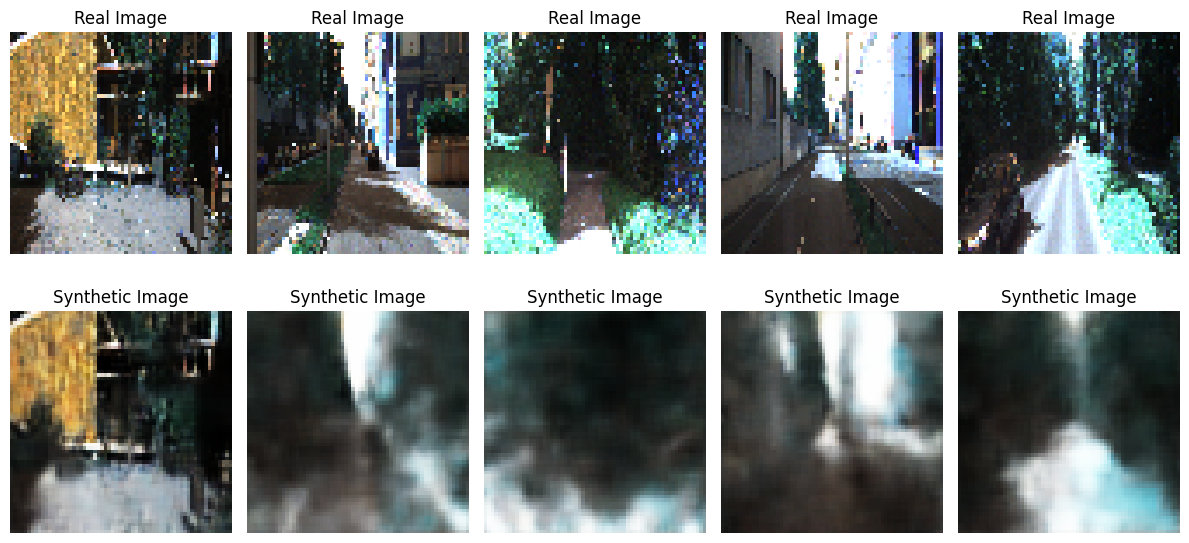

In [10]:
import matplotlib.pyplot as plt

# Function to visualize real and synthetic images
def display_images(real_images, vae_model, num_images=5):
    # Select a subset of real images
    real_images_subset = real_images[:num_images]

    # Generate synthetic images using the VAE
    synthetic_images = vae_model.predict(real_images_subset)

    # Plot the real and synthetic images
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        # Display real image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(real_images_subset[i])
        plt.title("Real Image")
        plt.axis("off")

        # Display synthetic image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(synthetic_images[i])
        plt.title("Synthetic Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize real vs synthetic images
display_images(test_images, vae, num_images=5)